# Fitting Models to Traits Data <a class="tocSkip">

<div id="toc"> </div>

## Introduction

### What are traits?

### Preliminaries 

These notes assume that you have already seen the [NLLS lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/Lectures/NLLS/Pawar_NLLS.pdf).  

We will work with examples to learn multiple techniques here: NLLS, MLE and Bayesian methods.

> *You might want to build separate R scripts for each of the examples*. In particular, create separate `code`, `data`, `results` directories, and `setwd()` to `code`.   
>
> For example, for the Allometry example below, create a new R script file called `Allometry_nlls.R` and save it to your `code` directory. Then build your script for tackling this particular example in that file.    

You may work in RStudio or any other code editor you prefer.

You will need the `nls.lm` R package, which you can install using the standard method (linux users, launch R in `sudo` mode first):

```r
install.packages("minpack.lm") 
```

Now, load the necessary packages, and clear all variables and graphic devices:

In [2]:
rm(list = ls())
graphics.off()

library("minpack.lm") # for Levenberg-Marquardt nls fitting
library("ggplot2")

*You will need to repeat these commands at the start of every new nlls script file you develop below.*

### Why use the nls.lm package?

The standard NLLS function in R, cals `nls` uses a less robust algorithm called the Gauss-Newton algorithm. Therefore, `nls` will often fail to fit your model to the data if you start off at starting values for the parameters that are too far from what the optimal vaues would be, especially if the "parameter space" is weirdly shaped, i.e., the model has a mathematical form that makes it hard to find parameter combinations that minimize the NLLS. If this does not makes ense, don't worry about it- just go with `nls_LM` from the `nls.lm` package instead of `nls`! If you are really curious, try substituting `nls` for `nls_LM` in the examples below and compare the results.  

## Allometric scaling of Traits

Let's start with a common and reasonably simple example from biology: [allometric scaling](https://en.wikipedia.org/wiki/Allometry). We will look at allometric scaling of body weight vs. total body length in dragonflies and damselfiles. 

Allometric relationships take the form:

<a id='eq:allom'></a>
\begin{equation} \label{eq:allom}
y = a x^b
\end{equation} 

where $x$ and $y$ are morphological measures (body length and body weight respectively, in our current example), the constant is the value of $y$ at body length $x = 1$ unit, and $b$ is the scaling "exponent". This is also called a power-law, because $y$ relates to $x$ through a simple power. 

First create a function object for the power law model:

In [3]:
powMod <- function(x, a, b) {
    return(a * x^b)
}

Now read in the [data](https://raw.githubusercontent.com/mhasoba/TheMulQuaBio/master/Data/GenomeSize.csv) (first click on link and use "Save as" or `Ctrl+S` to download it as a csv):

In [4]:
MyData <- read.csv("../Data/GenomeSize.csv")

head(MyData)

Suborder   Family    Species              GenomeSize GenomeSE GenomeN
1 Anisoptera Aeshnidae Aeshna canadensis    2.20         NA     1      
2 Anisoptera Aeshnidae Aeshna constricta    1.76       0.06     4      
3 Anisoptera Aeshnidae Aeshna eremita       1.85         NA     1      
4 Anisoptera Aeshnidae Aeshna tuberculifera 1.78       0.10     2      
5 Anisoptera Aeshnidae Aeshna umbrosa       2.00         NA     1      
6 Anisoptera Aeshnidae Aeshna verticalis    1.59         NA     1      
  BodyWeight TotalLength HeadLength ThoraxLength AdbdomenLength ForewingLength
1 0.159      67.58       6.83       11.81        48.94          45.47         
2 0.228      71.97       6.84       10.72        54.41          46.00         
3 0.312      78.80       6.27       16.19        56.33          51.24         
4 0.218      72.44       6.62       12.53        53.29          49.84         
5 0.207      73.05       4.92       11.11        57.03          46.51         
6 0.220      66.25       6.48       11.64        48.13          45.91         
  HindwingLength ForewingArea HindwingArea MorphologyN
1 45.40          369.57       483.61       2          
2 45.48          411.15       517.38       3          
3 49.47          460.72       574.33       1          
4 48.82          468.74       591.42       2          
5 45.97          382.48       481.44       1          
6 44.91          400.40       486.97       1

[Anisoptera](https://en.wikipedia.org/wiki/Dragonfly) are dragonflies, and [Zygoptera](https://en.wikipedia.org/wiki/Damselfly) are Damselflies. The variables of interest are `BodyWeight` and `TotalLength`.  Let's use the dragonflies data subset. 

So subset the data accordingly and remove NAs:

In [5]:
Data2Fit <- subset(MyData,Suborder == "Anisoptera")

Data2Fit <- Data2Fit[!is.na(Data2Fit$TotalLength),] # remove NA's

Plot it:

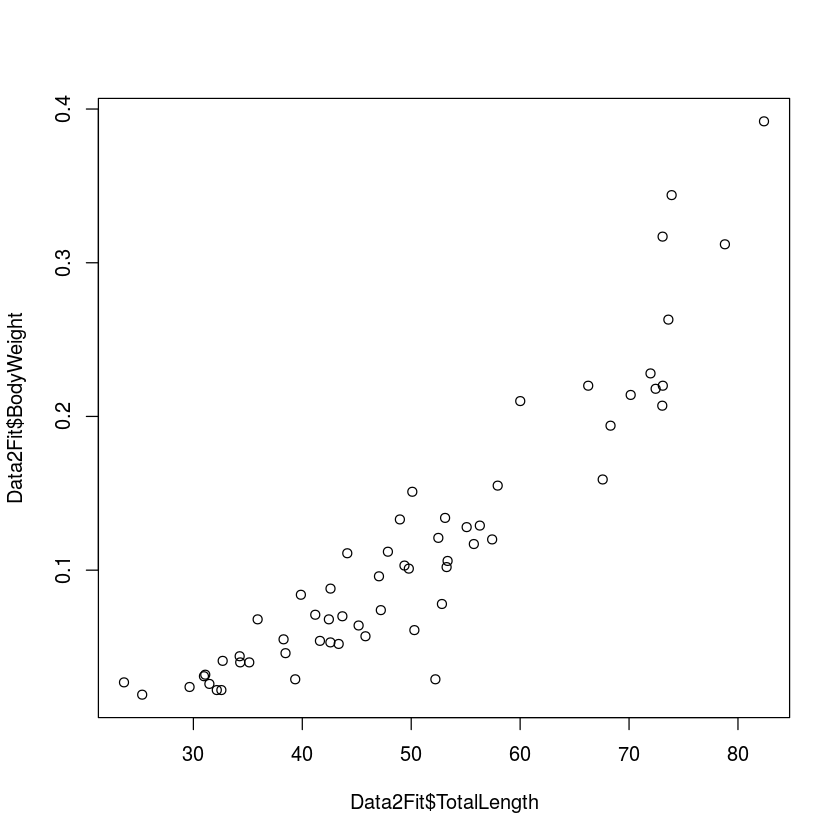

In [6]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)

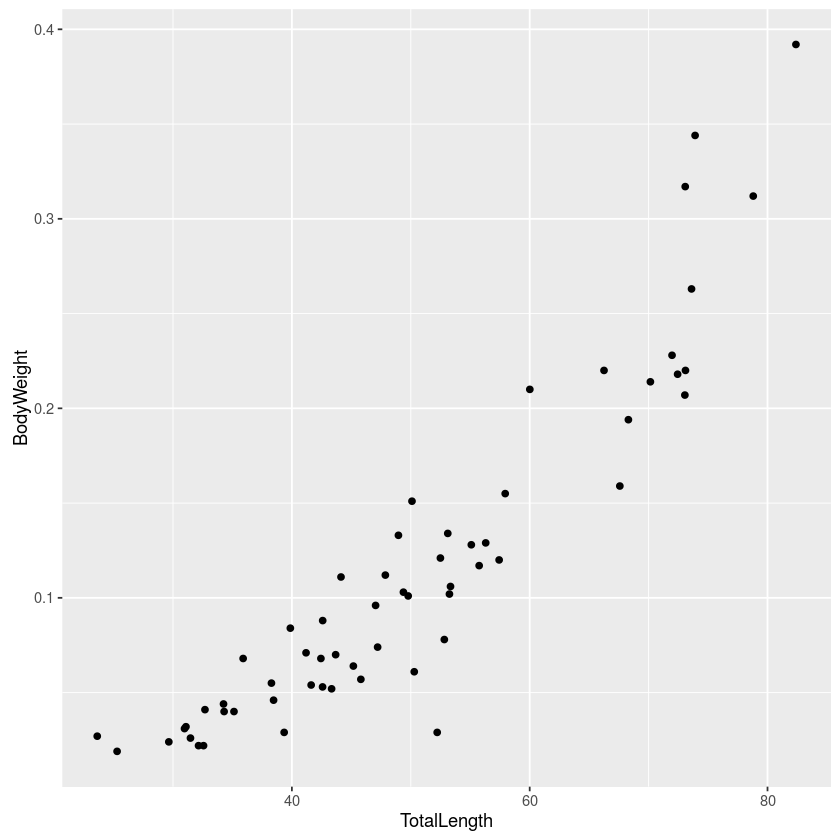

In [7]:
ggplot(Data2Fit, aes(x = TotalLength, y = BodyWeight)) + geom_point() # or using ggplot!

Now fit the model to the data using NLLS:

In [8]:
PowFit <- nlsLM(BodyWeight ~ powMod(TotalLength, a, b), data = Data2Fit, start = list(a = .1, b = .1))

We can use `summary()` just like we would for a `lm()` fit object. 

In [9]:
summary(PowFit)


Formula: BodyWeight ~ powMod(TotalLength, a, b)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.941e-06  2.234e-06   1.764    0.083 .  
b 2.585e+00  1.348e-01  19.174   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02807 on 58 degrees of freedom

Number of iterations to convergence: 39 
Achieved convergence tolerance: 1.49e-08


Most of the output is analogous to the output of an `lm()`. However, further statistucal inference here cannot be done using Analysis of Variance (ANOVA) (), because the mdoel is not a Linear Model. Try `anova(PowFit)`, and see what happens. The `Number of iterations to convergence: 39`, and `Achieved convergence tolerance: 1.49e-08` stem from the fact that NLLS requires computer simulations; revisit the [Lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/Lectures/NLLS/Pawar_NLLS.pdf) for an explanation of this.

Now let's visualize the fit. For this, first we need to generate a vector of body lengths (the x-axis variable) for plotting: 

In [10]:
Lengths <- seq(min(Data2Fit$TotalLength),max(Data2Fit$TotalLength),len=200)

Next, calculate the predicted line. For this, we will need to extract the coefficient from the model fit object using the `coef()`command. 

In [11]:
coef(PowFit)["a"]
coef(PowFit)["b"]

a 
3.940685e-06

b 
2.585048

So, we can do the following:

In [12]:
Predic2PlotPow <- powMod(Lengths,coef(PowFit)["a"],coef(PowFit)["b"])

Now plot the data and the fitted model line:

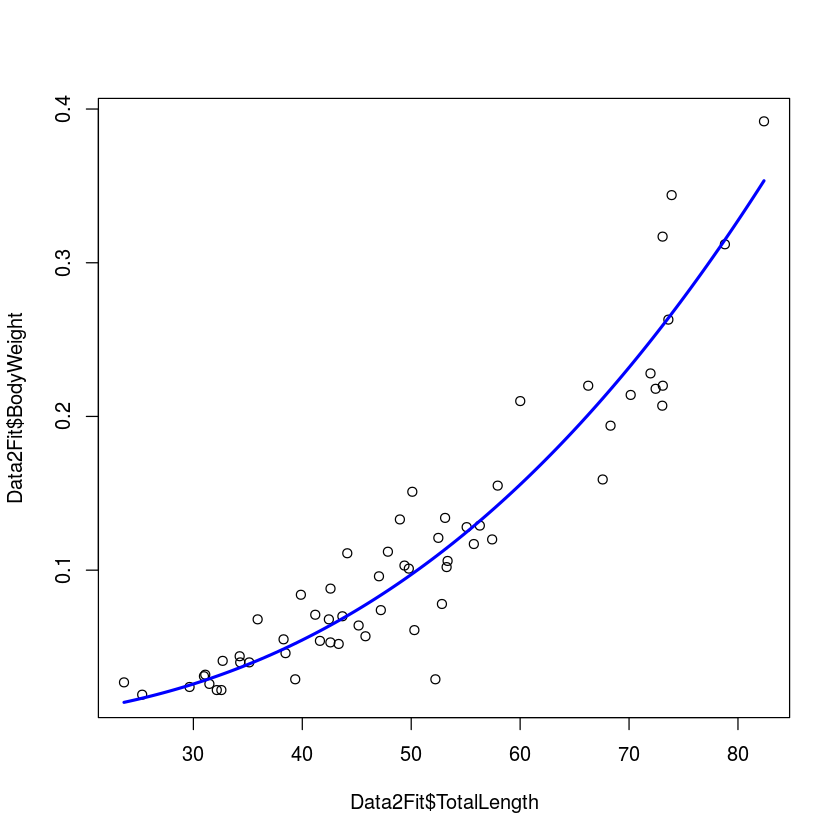

In [13]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)

We can claculate the confidence intervals on the estimated parameters as we would in OLS fitting used for Linear Models: 

In [14]:
confint(PowFit)

Waiting for profiling to be done...


2.5%         97.5%       
a 1.171935e-06 1.205273e-05
b 2.318292e+00 2.872287e+00

As you learnt before, a coefficient's CI should not include zero for it to be statistically significant (different from zero). 

#### Exercises <a id='Allom_Exercises'></a>

(a) Make the same plot as above, fitted line and all, in `ggplot`, and add (display) the equation you estimated to your new (ggplot) plot. The equation is: $\text{Weight} = 3.94 \times 10^{-06} \times \text{Length}^{2.59}$

(b) Try playing with the starting values, and see if you can "break" the model fit -- that is the NLLS fitting does not converge on a solution.

(c) Repeat the model fitting (incuding a-b above) using the Zygoptera data subset.

   
(d) There is an alternative (and in fact, more commonly-used) approach for fitting the allometric model to data: using Oridinary Least Squares on bi-logarithamically transformed data. That is, if you take a log of both sides of the [allometric equation](#eq:allom) we get,

$$
\log(y) = \log(a) + b \log(x)
$$

This is a straight line equation of the form $c = d + b z $, where $c = \log(c)$, $d = \log(a)$, $z = \log(x)$, and $b$ is now the slope parameter. So you can use Ordinary Least Squares and the linear models framework (with `lm()`) in R to estimate the parameters of the allometric equation. 

In this exercise, try comparing the NLLS vs OLS methods to se how much difference you get in the parameter estimates between them. For example, see the methods used in this paper by [Cohen et al 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3465447/).

(e) The allometry between Body weight and Length is not the end of the story, you have a number of other linear morphological measurements (`HeadLength`, `ThoraxLength`, `AdbdomenLength`, `ForewingLength`, `HindwingLength`, `ForewingArea`, and `HindwingArea`) that can also be investigated. In this exercise, you will try two lines of investigation (again, repeated separately for Dragonflies and Damselfiles): 

    (i) How do each of these measurs allometrically scale with Body length (obtain estimates of scaling constant and exponent)? (Hint: you may want to use the `pairs()` command in R to get an overview of all the pairs of potential scaling relationships. 
    
    (ii) Do any of the linear morphological measurements other than body length better predict Body weight? That is, does body weight scale more tightly with a linear morphological measurement other than total body length? 

### Comparing two models

*How do we know that there isn't a better or alternative model that adequately explains the pattern in your dataset?* 

This is important consideration in all data analyses (and more generally, the scientific method!), so you must aim to compare your NLLS model with an one or more alternatives for a more extensive and reliable investigation of the problem. 

Let's use  model comparison to investigate whether the relationship between body weight and length we found above is indeed allometric. For this, we need an alternative model that can be fitted to the same data. Let's try a quadratic curve, which is of the form:

$$y = a + b x + c x^2$$

This can also capture curvature in data, just as the [allometric equation](#eq:allom). Note that this mode is linear in its parameters (a linear model), which You can fit to the simply data using your favorite `lm()` function:   

In [15]:
QuaFit <- lm(BodyWeight ~ poly(TotalLength,2), data = Data2Fit)

And like before, we obtain the predicted values (but this time using the `predict.lm` function):

In [16]:
Predic2PlotQua <- predict.lm(QuaFit, data.frame(TotalLength = Lengths))

Now let's plot the two fitted models together:

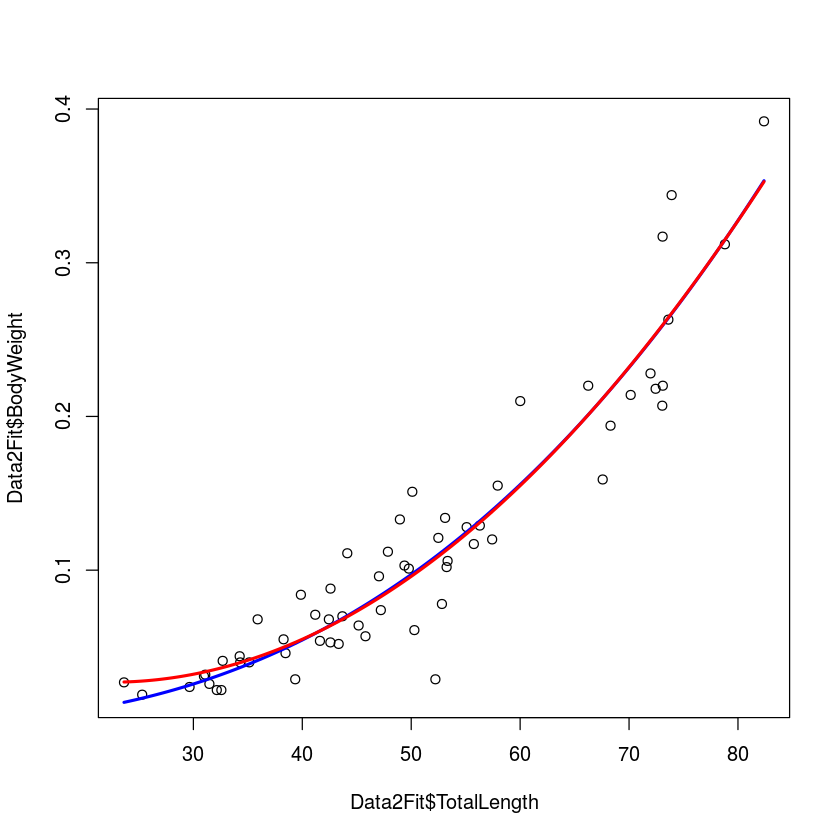

In [17]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)
lines(Lengths, Predic2PlotQua, col = 'red', lwd = 2.5)

Very similar fits, except that the quadratic model seems to get it wrong at the lower end of the data range. Let's do a proper/formal model comparison now to check which model better-fits the data.

Let's first calculate the R$^2$ values of the two fitted models:

In [18]:
RSS_Pow <- sum(residuals(PowFit)^2)  # Residual sum of squares
TSS_Pow <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Pow <- 1 - (RSS_Pow/TSS_Pow)  # R-squared value

RSS_Qua <- sum(residuals(QuaFit)^2)  # Residual sum of squares
TSS_Qua <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Qua <- 1 - (RSS_Qua/TSS_Qua)  # R-squared value

RSq_Pow 
RSq_Qua

[1] 0.9005475

[1] 0.9003029

Not very useful. In general, R$^2$ is a good measure of model fit, but cannot be used for model selection -- epecially not here, given the tiby difference in the R$^2$'s.

Instead, as discussed in the lecture, we can use the Akaike Information Criterion (AIC):

In [19]:
n <- nrow(Data2Fit) #set sample size
kPow <- length(coef(PowFit)) # get number of parameters in power law model
kQua <- length(coef(QuaFit)) # get number of parameters in quadratic model

AIC_Pow <- n * log((2 * pi) / n) + n + 2 + n * log(RSS_Pow) + 2 * kPow
AIC_Qua <- n * log((2 * pi) / n) + n + 2 + n * log(RSS_Qua) + 2 * kQua
AIC_Pow - AIC_Qua

[1] -2.147426

Of course, as you might have suspected, we can do this using an in-built function in R! 

In [20]:
AIC(PowFit) - AIC(QuaFit)

[1] -2.147426

*So which model wins?* As we had dicussed in the NLLS lecture, a rule of thumb is that a AIC value difference (typically denoted as $\Delta$AIC) > 2 is a acceptable cutoff for calling a winner. So the power law (allometric model) is a better fit here. Read the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/Readings/Modelling/JohnsonOmland2004.pdf) for more on model selection in Ecology and Evolution.    

#### Exercises

(a) Calculate the Bayesian Information Criterion (BIC), also know as the Schwarz Criterion (see your Lecture notes and the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/Readings/Modelling/JohnsonOmland2004.pdf), and use $\Delta$BIC to select the better fitting model. 

(b) Fit a straight line to the same data and compare with the allometric and quadratic models.

(c) Repeat the model comparison (incuding 1-2 above) using the Damselflies (Zygoptera) data subset -- does the allometric mdoel still win?

(d) Repeat exercise (e)(i) and (ii) from the [above set](#Allom_Exercises), biut with model comparison (e.g., again using a quadratic as a alternative model) to establish that the relationships are indeed allometric.

## Readings and Resources <a id='Readings'></a>

* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.
* Johnson, J. B. & Omland, K. S. 2004 Model selection in ecology and evolution. Trends Ecol. Evol. 19, 101–108.
* The [NCEAS non-linear modelling working group](https://groups.nceas.ucsb.edu/non-linear-modeling/projects/OrangeTree)
* [Mixed-Effects Models in S and S-PLUS](https://link.springer.com/book/10.1007/b98882)